# Summer School GIS HED2 2023

by Eduard Puig-Montella, Rémi Chassagne and Julien CHAUCHAT (LEGI, University of Grenoble Alpes, GINP/CNRS, Grenoble, France)

## Introduction
The aim of this practical session is to teach you how to use the Eulerian-Eulerian two-phase flow model sedFOAM through a series of tutorials distributed with the solver on gtihub at [https://github.com/sedfoam/sedfoam](https://github.com/sedfoam/sedfoam). The outline of the session is presented in this jupyter-notebook and the postprocessing will be performed using an openfoam package, fluidfoam, developped in python at LEGI [https://github.com/fluiddyn/fluidfoam](https://github.com/fluiddyn/fluidfoam). The documentation of fluidfoam is available here [https://fluidfoam.readthedocs.io/en/latest/](https://fluidfoam.readthedocs.io/en/latest/) 

During the session, you will have to type some commands in the system terminal to run the model. At the end of the session, two more advanced multi-dimensional configurations will be presented for which the model results are provided (no need to run the model) and the paraview software will be used for rendering. 


## 1. Sedimentation of particles at low particulate Reynolds number

This configuration has been presented in the lecture and more technical details are available online at: [http://sedfoam.github.io/sedfoam/tutorials.html](http://sedfoam.github.io/sedfoam/tutorials.html)

The input files of this 1D tutorial are located here: 

> _sedfoam_master/tutorials/laminar/1DSedim_ 

Open a terminal by either using the terminal from the system or the jupyter-lab terminal (File, New, Terminal). Change directory to the case file location using:

> _cd OpenFOAM/lubuntu-v1812/sedfoam_master/tutorials/laminar/1DSedim_

In order to run the model use the following sequence of commands:

1. Generate the mesh 

>  _blockMesh_
   

2. Copy the initial condition folder stored in 0_org

>  _cp  -r 0\_org 0_
  
   
   
3. Run sedFoam

>  _sedFoam\_rbgh_
   

the code will run for 1800 seconds in a couple minutes (duration depends on your computer capacity).

A postprocessing python script _plot\_tutoSedimentation.py_ using fluidfoam is available in _Document/sedfoam/tutorials/Py/_ but for the purpose of this practical session the script is directly embeded in the jupyter notebook together with explanations about what each part of the script is doing.

In the first section of the python script, some packages are loaded. The package _numpy_ is a very popular package for matrix manipulation and operation, the _fluidfoam_ package allows to read openFoam output and the _pylab_ and _matplotlib_ packages allows to make figures. As you will see, the syntax is very similar to _matlab_, the major difference is that the matrix element are denoted using [] instead of () and the indices starts at 0 instead of 1.

In [3]:
#
# Import section
#
import subprocess
import sys
import numpy as np
import fluidfoam
from pylab import figure, subplot, axis, xlabel, ylabel, show, savefig, plot
from pylab import title, matplotlib
import matplotlib.gridspec as gridspec
import matplotlib as mpl

In the following block, some basic configuration parameter are setup for figures

In [4]:
#
# Change fontsize
#
matplotlib.rcParams.update({'font.size': 20})
mpl.rcParams['lines.linewidth'] = 3
mpl.rcParams['lines.markersize'] = 10

In the next block, experimental data from Pham Van Bang et al. (2006) are read as well sedFoam results from 1DSedim case using _fluidfoam_

In [5]:
#########################################
#
# Loading experimental results
#
exec(open("Py/DATA/exp_lmsgc.py").read())
#########################################
# Loading OpenFoam results
#
case = '1DSedim'
sol = 'laminar/'+case + '/'
#
# Mesh size
#
Nx = 1
Ny = 120
Nz = 1
#
# Reading SedFoam results using openFoam command 'foamListTimes'
#
try:
    proc = subprocess.Popen(
        ['foamListTimes', '-case', sol], stdout=subprocess.PIPE)
#        ['foamListTimes', '-withZero', '-case', sol], stdout=subprocess.PIPE)
except:
    print("foamListTimes : command not found")
    print("Do you have load OpenFoam environement?")
    sys.exit(0)
# sort and split the resulting string    
output = proc.stdout.read()
tread = output.decode().rstrip().split('\n')

# remove last item and create matrices to store the results
del tread[-1]
Nt = len(tread)

time = np.zeros(Nt)
X, Y, Z = fluidfoam.readmesh(sol)
alphat = np.zeros((Ny, Nt))
pt = np.zeros((Ny, Nt))
pfft = np.zeros((Ny, Nt))

# loop of time list 'tread' items
k = -1
for t in tread:
    print("Reading time: %s s" % t)
    k = k + 1

    alphat[:, k] = fluidfoam.readscalar(sol, t + '/', 'alpha.a')
    pt[:, k] = fluidfoam.readscalar(sol, t + '/', 'p_rbgh')
    pfft[:, k] = fluidfoam.readscalar(sol, t + '/', 'pff')
    time[k] = float(t)

Reading file laminar/1DSedim//constant/polyMesh/owner
Reading file laminar/1DSedim//constant/polyMesh/faces
Reading file laminar/1DSedim//constant/polyMesh/points
Reading file laminar/1DSedim//constant/polyMesh/neighbour
Reading time: 20 s
Reading file laminar/1DSedim/20/alpha.a
Reading file laminar/1DSedim/20/p_rbgh
Reading file laminar/1DSedim/20/pff
Reading time: 40 s
Reading file laminar/1DSedim/40/alpha.a
Reading file laminar/1DSedim/40/p_rbgh
Reading file laminar/1DSedim/40/pff
Reading time: 60 s
Reading file laminar/1DSedim/60/alpha.a
Reading file laminar/1DSedim/60/p_rbgh
Reading file laminar/1DSedim/60/pff
Reading time: 80 s
Reading file laminar/1DSedim/80/alpha.a
Reading file laminar/1DSedim/80/p_rbgh
Reading file laminar/1DSedim/80/pff
Reading time: 100 s
Reading file laminar/1DSedim/100/alpha.a
Reading file laminar/1DSedim/100/p_rbgh
Reading file laminar/1DSedim/100/pff
Reading time: 120 s
Reading file laminar/1DSedim/120/alpha.a
Reading file laminar/1DSedim/120/p_rbgh
Read

In the next block, the experimental and numerical data are postprocessed to extract the interface positions:
- zint = upper interface between the clear fluid (alpha=0) and the sedimenting suspension (alpha=0.5)
- zint2 = lower interface between the sedimenting suspension (alpha=0.5) and the deposited particle layer (alpha=0.6)

These two positions are then plotted as a function of time for the experimental and numerical data.

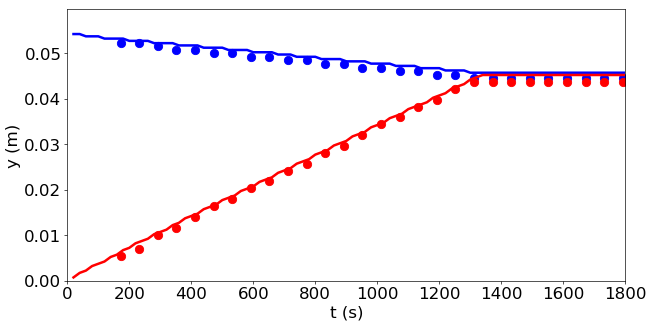

In [6]:
#
# Figure size
#
figwidth = 12
figheight = 6
#
# parameters
#
zmin = 0.
zmax = np.max(Y)

tmax = 1800.
tadj = 172.
#
# calcul zint et zint2
#
if Nt > 1:

    asint2 = 0.55
    asint = 0.25

    zint = np.zeros(Nt)
    zint2 = np.zeros(Nt)

    for i in np.arange(Nt):
        # zint
        toto = np.where(alphat[:, i] < asint)
        if np.size(toto) == 0:
            zint[i] = Y[Ny - 1]
        else:
            zint[i] = Y[toto[0][0]]
    # zint2
        toto2 = np.where(alphat[:, i] <= asint2)
        if np.size(toto2) == 0:
            zint2[i] = Y[0]
        else:
            zint2[i] = Y[toto2[0][0]]
    #
    # FIGURE 1: Interface positions Vs Time
    #
    figure(num=1, figsize=(figwidth, figheight),dpi=60, facecolor='w', edgecolor='w')

    plot(t_pvb + tadj, zint_pvb + 0.1, 'ob',
         t_pvb + tadj, zint2_pvb + 0.1, 'or')
    plot(time, zint, '-b', time, zint2, '-r')
    ylabel('y (m)')
    xlabel('t (s)')
    axis([0, tmax, zmin, zmax])

The settling curves plotted above clearly demonstrate that the model is able to reproduce very well the sedimentation of particles. This problem is known for a long time and can be solved analytically using the characteristic method (Kynch, 1952). The major challenge in Eulerian-Eulerian two-phase flow modeling framework is to account for the elastic part of the solid phase stress (the so-called effective stress in soil mechanics) in a viscous framework. This is done here by using Johnson and Jackson (1987) model but this is clearly not optimum and other modeling options are possible and should be developped in the future.

In order to further validate the model we can plot the concentration profiles at different instants during the sedimentation and compare them with experiments. This is done by the python code in the next block

texp= 232.0s - tnum=240.0s
texp= 652.0s - tnum=660.0s
texp= 1072.0s - tnum=1080.0s
texp= 1492.0s - tnum=1500.0s


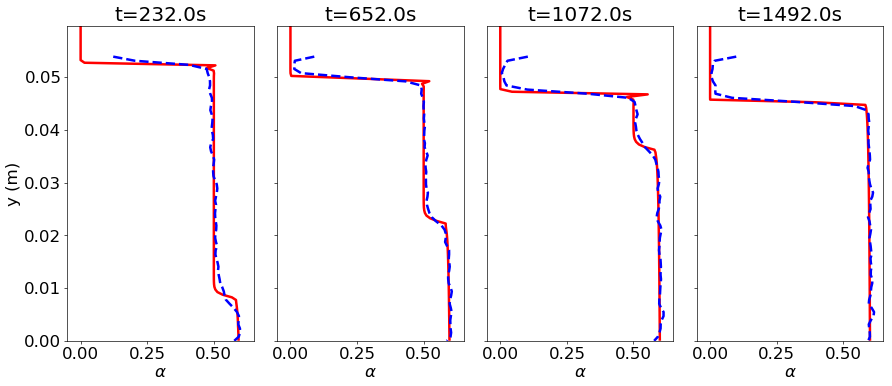

In [7]:
#
# Figure 2: Concentration profiles
#
#
# Change subplot sizes
#
gs = gridspec.GridSpec(1, 4)
gs.update(left=0.1, right=0.95, top=0.95, bottom=0.075, wspace=0.125, hspace=0.125)
#
# Figure size
#
figwidth = 16
figheight = 6

figure(num=2, figsize=(figwidth, figheight), dpi=60, facecolor='w', edgecolor='w')

for i in np.arange(4):
    if i == 0:
        ax = subplot(gs[0, 0])
    elif i == 1:
        ax = subplot(gs[0, 1])
    elif i == 2:
        ax = subplot(gs[0, 2])
    elif i == 3:
        ax = subplot(gs[0, 3])

    iexp = 7 * i + 1
    titi = np.where(time[:] >= t_pvb[0][iexp] + tadj)
    if np.size(titi) == 0:
        inum = Nt - 1
    else:
        inum = titi[0][0]
    print('texp= ' + str(t_pvb[0][iexp] + tadj) + 's - tnum='+ str(time[inum]) + 's')

    ax.plot(alphat[:, inum], Y[:], '-r',
            as_pvb[:, iexp], z_pvb[:, iexp] + 0.1, '--b')
    title('t=' + str(t_pvb[0][iexp] + tadj) + 's')
    axis([-0.05, 0.65, zmin, zmax])
    if (i == 0):
        ylabel('y (m)')
    else:
        ax.set_yticklabels([''])
    xlabel(r'$\alpha$')
    

As you can see the interface dynamics are well captured by the two-phase model however an oscilation of concentration appears at the upper interface which is not physical. This is probably due to the hyperbolic nature of the mass conservation equation for the solid phase. The steep gradient of concentration can probably assimilated to a shock and would require a shock-capturing scheme. Another alternative would be to add diffusion in the mass conservation to make the equation parabolic. Anyway, the goal of this simulation was to obtain a stable deposited sediment bed and this goal is achieved in the last panel.

Now before turning on the flow we want to make sure the particle pressure distribution is well reproduced by the model.  In the following block, the particle pressure profile as well as excess pore pressure profile for the fluid phase are plotted at different instants.

texp= 172.0s - tnum=20.0s
texp= 352.0s - tnum=320.0s
texp= 652.0s - tnum=620.0s
texp= 952.0s - tnum=920.0s
texp= 1192.0s - tnum=1180.0s


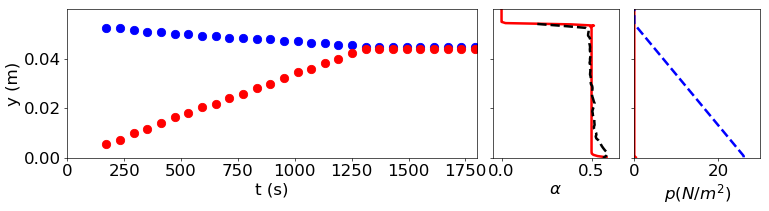

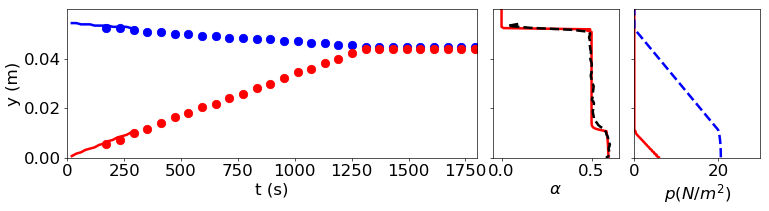

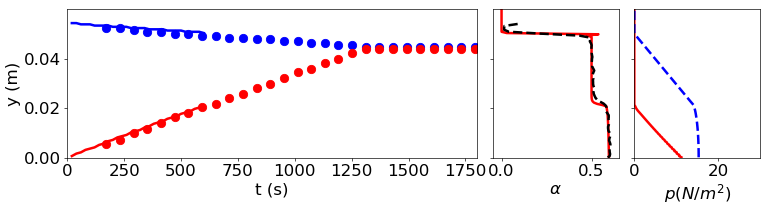

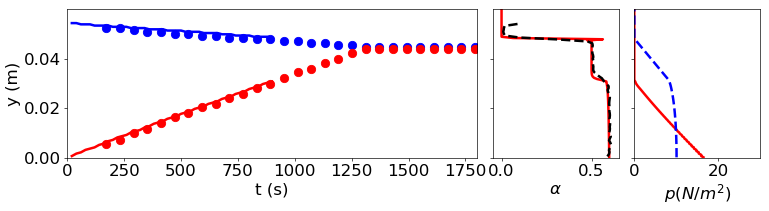

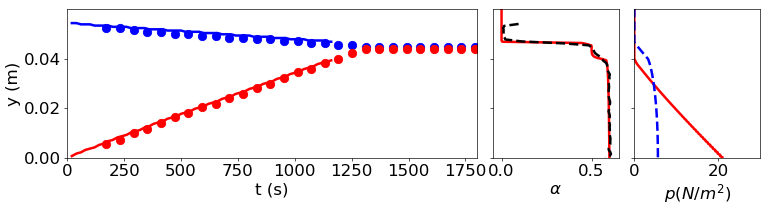

In [8]:
#
# FIGURE 3: Interface positions Vs Time + concentration + pressure
#
# Change subplot sizes
#
gs2 = gridspec.GridSpec(1, 5)
gs2.update(left=0.1, right=0.925, top=0.925, bottom=0.1, wspace=0.125, hspace=0.125)
#
# Figure size
#
figwidth = 14
figheight = 6

time_list=[0,15,30,45,58]
for k in np.arange(5):
    i=time_list[k]
    figure(num=3+i, figsize=(figwidth, figheight/2),dpi=60, facecolor='w', edgecolor='w')
    ax = subplot(gs2[0, 0:3])
    ax.plot(t_pvb + tadj, zint_pvb + 0.1, 'ob',
            t_pvb + tadj, zint2_pvb + 0.1, 'or')
    ax.plot(time[0:i], zint[0:i], '-b', time[0:i], zint2[0:i], '-r')
    ylabel('y (m)')
    xlabel('t (s)')
    axis([0, tmax, zmin, zmax])

    iexp = np.min(np.where(t_pvb[0][:] + tadj >time[i]))

    print('texp= ' + str(t_pvb[0][iexp] + tadj) + 's - tnum='+ str(time[i]) + 's')
    ax2 = subplot(gs2[0, 3])
    ax2.plot(alphat[:, i], Y[:], '-r')
    ax2.plot(as_pvb[:, iexp], z_pvb[:, iexp] + 0.1, '--k')

    ax2.axis([-0.05, 0.65, zmin, zmax])
    ax2.set_yticklabels([''])
    xlabel(r'$\alpha$')

    ax3 = subplot(gs2[0, 4])
    ax3.plot(pfft[:, i], Y[:], '-r')
    ax3.plot(pt[:, i], Y[:], '--b')
    ax3.axis([0.0, 30, zmin, zmax])
    ax3.set_yticklabels([''])
    xlabel(r'$p (N/m^{2})$')

In these graphs, you can see that while the particle pressure is building up in the deposited particle layer the excess pore pressure dissipates. This is a well known problem in geomechanics and the time-lag between excess pore pressure dissipation and the particle pressure distribution is controlled by the permeability of the porous media. The final particle pressure distribution  is hydrostatic and the vertical gradient compensates the buoyant weitght of the particles. The acurate prediction of the particle pressure distribution is of outmost importance for simulating bedload transport as the granular rheology is based on a Coulomb frictional model in which the yield stress is given as _mu\_s p^p_.

## 2. Laminar bedload transport

We know turn to the more complex problem of laminar bedload. In the previous exemple, the particles have settled down to  form a rigid bed (as illustrated above). Building up upon this configuration, we can now add a streamwise pressure gradient to drive a fluid flow in the x direction. This can be done by modifying the file:

>_constant/forceProperties_

and set the variable gradPMEAN to (80 0 0). Your _forceProperties_ file should look like that:

Once this done you further need to modify the file:

>_system/controlDict_

to change the startTime to 1800 s and the endTime to 1900 s with output interval (writeInterval) every 20 s.

Then, you can run sedFoam again by typping the following command in the terminal:

>_sedFoam&#95;rbgh > log &_ 

The code is now running in batch mode and the standard output is written in the log file. You can access the bottom of the file by using the command:

>_tail -100 log_

Once the first output is written (t=1820 s), you can use the piece of python code below to compare your simulation with the analytical solution from Aussillous et al. (2013). We are solving for a transient problem to get to steady state solution meaning that you have to wait long enough to make sure the solution has converged. 

In the next code block, the analmytical solution is computed and made dimensional for the same configuration as the numerical simulation.

In [15]:
import sys
sys.path.append("Py/") 

from analytic_coulomb2D import *
#
#
#
zmin = 0.
zmax = 0.06
#
# compute the analytical solution in dimensionless form
#
nx = 60
xex = np.linspace(0, 1., nx)
# dimensionless parameters
mus = 0.32
phi0 = 0.6
eta_e = (1. + 2.5 * phi0)
# dimensional parameters
D = 0.06
rho_f = 950.
rho_p = 1050.
drho = rho_p - rho_f
etaf = 2.105e-5*rho_f
g = 9.81

hp = 0.0455/D 
# pressure gradient
dpdx = -80e0 / (drho * g)

# Compute the analytical solution
alphaex = np.ones(nx) * phi0
toto = np.where(xex[:] > hp)
alphaex[toto] = 0.

pex = np.zeros(nx)
for i in range(nx):
    if alphaex[nx - i - 1] > 0.:
        pex[nx - i - 1] = pex[nx - i] + alphaex[nx - i] * \
            (xex[nx - i] - xex[nx - i - 1])

[uex, hc] = analytic_coulomb2D(nx, xex, dpdx, hp, mus, phi0, eta_e)

duxmax = 0.
nuex = np.zeros(nx)
for i in range(nx - 1):
    duexdz = (uex[i] - uex[i - 1]) / (xex[i] - xex[i - 1])
    duxmax = max([duxmax, duexdz])
    nuex[i] = mus * pex[i] / (rho_p * (np.abs(duexdz) + 1e-6))
#
# dimensional form
#
U0 = drho * g * D**2 / etaf
uex = uex * U0
xex = xex * D
pex = pex * drho * g * D

print("max(uex)=" + str(np.max(uex)) + " m/s")

max(uex)=0.11881299205837008 m/s


In the following, the numerical solution is read using fluidfoam and the concentration, velocity and pressure profiles are compared with this analytical solution. 

Reading file laminar/1DSedim//constant/polyMesh/owner
Reading file laminar/1DSedim//constant/polyMesh/faces
Reading file laminar/1DSedim//constant/polyMesh/points
Reading file laminar/1DSedim//constant/polyMesh/neighbour
Reading file laminar/1DSedim/1900/alpha.a
Reading file laminar/1DSedim/1900/U.a
Reading file laminar/1DSedim/1900/U.b
Reading file laminar/1DSedim/1900/pff
Reading file laminar/1DSedim/1900/p_rbgh
max(Ub)=0.11954 m/s


[Text(0, 0, '')]

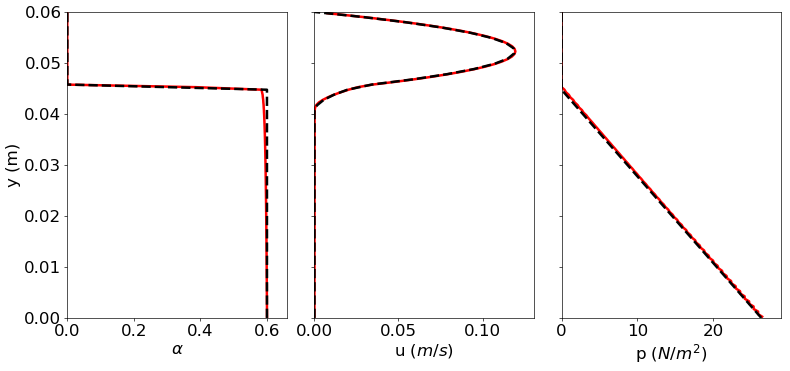

In [16]:
#
# Change subplot sizes
#
gs = gridspec.GridSpec(1, 3)
gs.update(left=0.1, right=0.95, top=0.95,bottom=0.1, wspace=0.125, hspace=0.25)
#########################################
# Reading SedFoam results
#########################################
proc = subprocess.Popen(
    ['foamListTimes', '-case', sol, '-latestTime'], stdout=subprocess.PIPE)
output = proc.stdout.read()
tread = output.decode().rstrip()
if float(tread)>1900:
    tread='1900'
tread=tread+'/'

X, Y, Z = fluidfoam.readmesh(sol)
alpha = fluidfoam.readscalar(sol, tread, 'alpha.a')
Ua = fluidfoam.readvector(sol, tread, 'U.a')
Ub = fluidfoam.readvector(sol, tread, 'U.b')
pff = fluidfoam.readscalar(sol, tread, 'pff')
p = fluidfoam.readscalar(sol, tread, 'p_rbgh')

Ny = np.size(Y)
U = np.zeros(Ny)
U = alpha[:] * Ua[0, :] + (1 - alpha[:]) * Ub[0, :]

print("max(Ub)=" + str(np.amax(Ub)) + " m/s")

#########################################
# figure 1
#########################################

figure(num=1, figsize=(figwidth, figheight), dpi=60, facecolor='w', edgecolor='w')

ax1 = subplot(gs[0, 0])
l11, = ax1.plot(alpha[:], Y[:], '-r')
l1, = ax1.plot(alphaex[:], xex[:], '--k')
ax1.set_ylabel('y (m)')
ax1.set_xlabel(r'$\alpha$')
ax1.set_xlim(0,  np.max(np.max(alpha)) * 1.1)
ax1.set_ylim(zmin, zmax)

ax2 = subplot(gs[0, 1])
l21, = ax2.plot(U[:], Y[:], '-r')
l2, = ax2.plot(uex[:], xex[:], '--k')
ax2.set_xlabel('u ($m/s$)')
ax2.set_xlim(0,  np.max(uex) * 1.1)
ax2.set_ylim(zmin, zmax)
ax2.set_yticklabels([''])

ax3 = subplot(gs[0, 2])
l31, = ax3.plot(pff[:], Y[:], '-r')
l3, = ax3.plot(pex[:], xex[:], '--k')
ax3.set_xlabel('p ($N/m^2$)')
ax3.set_xlim(0,  np.max(pex) * 1.1)
ax3.set_ylim(zmin, zmax)
ax3.set_yticklabels([''])

As you see the velocity ans particle pressure profiles are in very good agreement with the analytical solution even though the concentration exhibits a slight discrepancy at the bed interface. This is because the continuum two-phase flow model smooths out the sharp concentration gradient and the empirical particle pressure model introduces a very small vertical concentration gradient inside the sediment bed. 

Overall the numerical results are satisfactory and we can now complexify the model closures by moving from Coulomb rheology to the mu(Iv) rheology. This is done by changing the keyword _FrictionModel_ in _constant/granularRheologyProperties_ from _Coulomb_ to _MuIv_. 

Then you need to modify the file _system/controlDict_ to run from 1900 s to 2000 s. 

Go to the terminal and run

>_sedFoam&#95;rbgh_.

Now we will run the same postprocessing script but this time the numerical solution should be different from the analytical one as we changed the rheological model.

Reading file laminar/1DSedim//constant/polyMesh/owner
Reading file laminar/1DSedim//constant/polyMesh/faces
Reading file laminar/1DSedim//constant/polyMesh/points
Reading file laminar/1DSedim//constant/polyMesh/neighbour
Reading file laminar/1DSedim/2000/alpha.a
Reading file laminar/1DSedim/2000/U.a
Reading file laminar/1DSedim/2000/U.b
Reading file laminar/1DSedim/2000/pff
Reading file laminar/1DSedim/2000/p_rbgh
max(Ub)=0.109772 m/s


[Text(0, 0, '')]

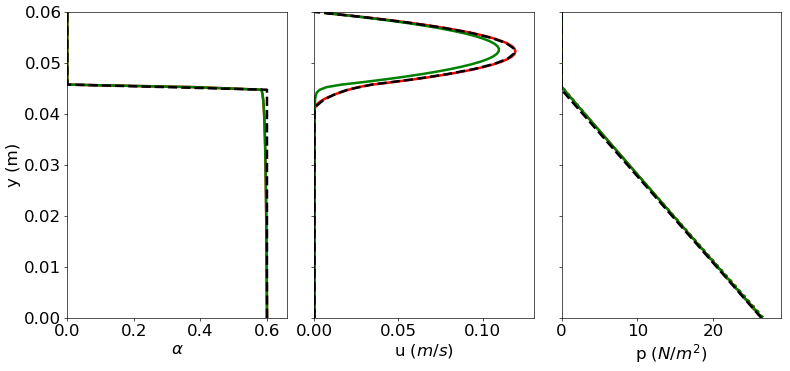

In [17]:
#########################################
# Reading SedFoam results
#########################################
proc = subprocess.Popen(
    ['foamListTimes', '-case', sol, '-latestTime'], stdout=subprocess.PIPE)
output = proc.stdout.read()
tread = output.decode().rstrip()
if float(tread)>2000:
    tread='2000'
tread=tread+'/'

X1, Y1, Z1 = fluidfoam.readmesh(sol)
alpha1 = fluidfoam.readscalar(sol, tread, 'alpha.a')
Ua1 = fluidfoam.readvector(sol, tread, 'U.a')
Ub1 = fluidfoam.readvector(sol, tread, 'U.b')
pff1 = fluidfoam.readscalar(sol, tread, 'pff')
p1 = fluidfoam.readscalar(sol, tread, 'p_rbgh')

Ny1 = np.size(Y1)
U1 = np.zeros(Ny1)
U1 = alpha1[:] * Ua1[0, :] + (1 - alpha1[:]) * Ub1[0, :]

print("max(Ub)=" + str(np.amax(Ub1)) + " m/s")

#########################################
# figure 1
#########################################

figure(num=1, figsize=(figwidth, figheight),
       dpi=60, facecolor='w', edgecolor='w')

ax1 = subplot(gs[0, 0])
l11, = ax1.plot(alpha[:], Y[:], '-r')
l12, = ax1.plot(alpha1[:], Y[:], '-g')
l1, = ax1.plot(alphaex[:], xex[:], '--k')
ax1.set_ylabel('y (m)')
ax1.set_xlabel(r'$\alpha$')
ax1.set_xlim(0,  np.max(np.max(alpha)) * 1.1)
ax1.set_ylim(zmin, zmax)

ax2 = subplot(gs[0, 1])
l21, = ax2.plot(U[:], Y[:], '-r')
l22, = ax2.plot(U1[:], Y1[:], '-g')
l2, = ax2.plot(uex[:], xex[:], '--k')
ax2.set_xlabel('u ($m/s$)')
ax2.set_xlim(0,  np.max(uex) * 1.1)
ax2.set_ylim(zmin, zmax)
ax2.set_yticklabels([''])

ax3 = subplot(gs[0, 2])
l31, = ax3.plot(pff[:], Y[:], '-r')
l32, = ax3.plot(pff1[:], Y1[:], '-g')
l3, = ax3.plot(pex[:], xex[:], '--k')
ax3.set_xlabel('p ($N/m^2$)')
ax3.set_xlim(0,  np.max(pex) * 1.1)
ax3.set_ylim(zmin, zmax)
ax3.set_yticklabels([''])

As you can see, by changing the rheological model, the velocity profile in the moving granular layer changes from parabolic (Coulomb) to exponential (mu(Iv)) which is consistent with experimental observations. Also the fact that the velocity magnitude is reduced shows that the overall dissipation induced by the mu(Iv) rheology is much higher than with the Coulomb rheology.

So far the concentration profile remained fixed because no dilatancy effect has been introduced. In the next step, we propose to turn on the dilatancy model of the granular rheology (phi(Iv)) by changing the keyword _PPressureModel_ in _constant/granularRheologyProperties_ from _none_ to _MuIv_. 

Before running the model you need modify _system/controlDict_ to run from 2000 s to 2100 s. 

Go to the terminal and run

>_sedFoam&#95;rbgh_.

The next python code block allows you to plot the results

Reading file laminar/1DSedim//constant/polyMesh/owner
Reading file laminar/1DSedim//constant/polyMesh/faces
Reading file laminar/1DSedim//constant/polyMesh/points
Reading file laminar/1DSedim//constant/polyMesh/neighbour
Reading file laminar/1DSedim/2100/alpha.a
Reading file laminar/1DSedim/2100/U.a
Reading file laminar/1DSedim/2100/U.b
Reading file laminar/1DSedim/2100/pa
Reading file laminar/1DSedim/2100/pff
Reading file laminar/1DSedim/2100/p_rbgh
max(Ub2)=0.101048 m/s


[Text(0, 0, '')]

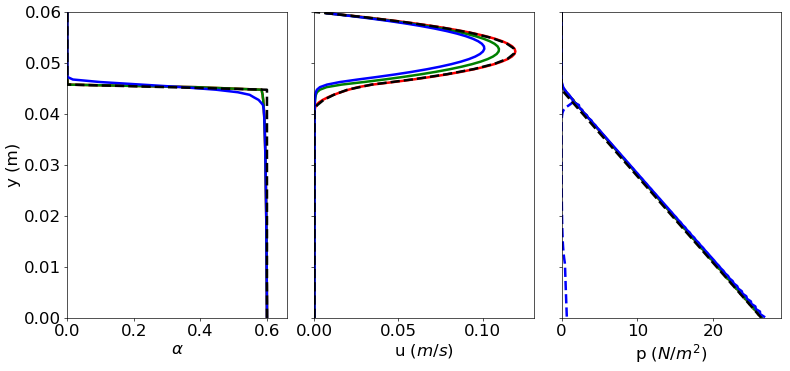

In [19]:
#########################################
# Reading SedFoam results
#########################################
proc = subprocess.Popen(
    ['foamListTimes', '-case', sol, '-latestTime'], stdout=subprocess.PIPE)
output = proc.stdout.read()
tread = output.decode().rstrip() + '/'

X2, Y2, Z2 = fluidfoam.readmesh(sol)
alpha2 = fluidfoam.readscalar(sol, tread, 'alpha.a')
Ua2 = fluidfoam.readvector(sol, tread, 'U.a')
Ub2 = fluidfoam.readvector(sol, tread, 'U.b')
pa2 = fluidfoam.readscalar(sol, tread, 'pa')
pff2 = fluidfoam.readscalar(sol, tread, 'pff')
p2 = fluidfoam.readscalar(sol, tread, 'p_rbgh')

Ny2 = np.size(Y2)
U2 = np.zeros(Ny2)
U2 = alpha2[:] * Ua2[0, :] + (1 - alpha2[:]) * Ub2[0, :]

print("max(Ub2)=" + str(np.amax(Ub2)) + " m/s")

#########################################
# figure 1
#########################################

figure(num=1, figsize=(figwidth, figheight), dpi=60, facecolor='w', edgecolor='w')

ax1 = subplot(gs[0, 0])
l11, = ax1.plot(alpha[:], Y[:], '-r')
l12, = ax1.plot(alpha1[:], Y1[:], '-g')
l13, = ax1.plot(alpha2[:], Y2[:], '-b')
l1, = ax1.plot(alphaex[:], xex[:], '--k')
ax1.set_ylabel('y (m)')
ax1.set_xlabel(r'$\alpha$')
ax1.set_xlim(0,  np.max(np.max(alpha)) * 1.1)
ax1.set_ylim(zmin, zmax)

ax2 = subplot(gs[0, 1])
l21, = ax2.plot(U[:], Y[:], '-r')
l22, = ax2.plot(U1[:], Y1[:], '-g')
l23, = ax2.plot(U2[:], Y2[:], '-b')
l2, = ax2.plot(uex[:], xex[:], '--k')
ax2.set_xlabel('u ($m/s$)')
ax2.set_xlim(0,  np.max(uex) * 1.1)
ax2.set_ylim(zmin, zmax)
ax2.set_yticklabels([''])

ax3 = subplot(gs[0, 2])
l31, = ax3.plot(pff[:], Y[:], '-r')
l32, = ax3.plot(pff1[:], Y1[:], '-g')
l33, = ax3.plot(pff2[:]+pa2[:], Y2[:], '-b')
l34, = ax3.plot(pa2[:], Y2[:], '--b')
l3, = ax3.plot(pex[:], xex[:], '--k')
ax3.set_xlabel('p ($N/m^2$)')
ax3.set_xlim(0,  np.max(pex) * 1.1)
ax3.set_ylim(zmin, zmax)
ax3.set_yticklabels([''])

As you can immediately see, the concentration profile has changed and now exhibits a smoother vertical gradient between the fixed particle bed layer and the pure fluid layer. This modification is due to the shear induced pressure contribution represented as a dashed blue line in the right panel. This pressure contribution actually non-linearly couples the streamwise and wallnormal momentum balance equations for the solid phase as the shear induced pressure is proportional to the velocity shear rate squared. When dilatancy effect are added to the model, the dissipation is again increased  leading to lower fluid velocity in the the pure fluid layer. 

So far turbulence was not relevant as the bulk Reynolds number remained below the critical value of 3000. If you want to get familiar with turbulence modeling in the two-phase flow model framework please read [Chauchat et al. (2017)](https://www.geosci-model-dev.net/10/4367/2017/gmd-10-4367-2017.pdf) and run the tutorial 1DSheetFlow available in the github repository.  

## 3. 2D Scour around a horizontal cylinder

SedFoam can be used to simulate more complex multi-dimensional configurations like scour under a horizontal pipeline.

The erosion under a submarine pipeline can be decomposed into three steps: 
1. The onset: when the current around the cylinder is strong enough, it generates a pressure drop, which liquefies the sediments underneath the cylinder;
2. the tunneling stage: when a breach is formed between the cylinder and the sediment bed, it expands due to the strong current in the breach;
3. the lee-wake erosion stage: when the gap is large enough, vortices are shed in the wake of the cylinder, leading to erosion downstream of the scour hole.

Two configurations are presented in this tutorial using different turbulence models ($k-\varepsilon$ and $k-\omega$ models).

Since the simulations take a lot of time and computer ressources, the simulation results are directly available.

The simulation results can be visualized using paraview software. To do so, go to the directory containing the visualization file by typing the following command in the terminal:

>_cd ~/Documents/2DScourPipeline_

Now, to visualize the results from the configuration using the $k-\varepsilon$ model, type the following command:

>_paraview 2DPipeline.pvsm &_

To switch to the visualization of the configuration using the $k-\omega$ model, in paraview click on:

>_File -> Load State..._

select the file:

>_2DPipeline.pvsm_

then, select:

>_Choose File Names_

and choose the file _empy.foam_ in the $k-\omega$ case directory:

>_2D&#95;Lee&#95;shield0p33&#95;MuI&#95;komega2006/empty.foam_

Finally, to compare the results obtained from the two simulations and experimental data from Mao (1986), the following python script generates plots containing the bed interface at 11, 18 and 25 seconds.

In [ ]:
from pylab import mlab
import matplotlib.pyplot as plt


# Function returning the bed profile
def depth(sol, t, x, y, xi, yi):
    ybed = np.zeros(len(xi))
    if np.mod(t, 1) == 0:
        timename = str(int(t)) + '/'
    else:
        timename = str(t) + '/'
    alpha = fluidfoam.readscalar(sol, timename, 'alpha.a')
    alphai = mlab.griddata(x, y, alpha, xi, yi, interp='linear')
    for j in range(len(xi) - 1):
        tab = np.where(alphai[:, j+1] > 0.5)
        ybed[j] = yi[np.max(tab)]
    return ybed

# Case information
base_path = '../../2DScourPipeline/'
cases_toplot = [base_path + '2D_Lee_shield0p33_MuI_kepsilon',
                base_path + '2D_Lee_shield0p33_MuI_komega2006']
time1 = 11
time2 = 18
time3 = 25

# -------------PLOT SECTION------------- #
# Figure dimensions and parameters
fig_sizex = 27.5
fig_sizey = 37
font_size = 40
line_style = '-'
line_width = 4
marker_size = 16
label_expe = 'Mao [1986]'
label_num = [r'$k-\varepsilon$',
             r'$k-\omega2006$']
line_color = ['C1',
              'C2']

# Domain dimensions
D = 0.05
xmin = -0.1
xmax = 0.3
ymin = -0.08
ymax = 0.075

# Figure creation
fig = plt.figure(figsize=(fig_sizex, fig_sizey), dpi=100)
plt.rcParams.update({'font.size': font_size})

# Subplots creation
# Subplot 1
plt1 = plt.subplot(3, 1, 1)
circle = plt.Circle((0, 0), radius=0.5, fc='silver', edgecolor='k',
                    zorder=3)
plt.gca().add_patch(circle)
plt1.set_xticklabels([])
plt1.grid()

# Subplot 2
plt2 = plt.subplot(3, 1, 2, sharey=plt1)
circle = plt.Circle((0, 0), radius=0.5, fc='silver', edgecolor='k',
                    zorder=3)
plt.gca().add_patch(circle)
plt2.set_xticklabels([])
plt2.grid()

# Subplot 3
plt3 = plt.subplot(3, 1, 3, sharey=plt1)
circle = plt.Circle((0, 0), radius=0.5, fc='silver', edgecolor='k',
                    zorder=3)
plt.gca().add_patch(circle)
plt3.grid()

plt.subplots_adjust(hspace=0.2)

# Subplot axis
plt1.axis([xmin/D, xmax/D, ymin/D, ymax/D])
plt2.axis([xmin/D, xmax/D, ymin/D, ymax/D])
plt3.axis([xmin/D, xmax/D, ymin/D, ymax/D])
plt1.set_xlabel('')
plt1.set_ylabel('y/D')
plt2.set_ylabel('y/D')
plt3.set_xlabel('x/D')
plt3.set_ylabel('y/D')

# Horizontal line at y = 0
n = np.zeros(2)
nx = np.linspace(xmin/D, xmax/D, 2)
plt1.plot(nx, n-0.5, "k--")
plt2.plot(nx, n-0.5, "k--")
plt3.plot(nx, n-0.5, "k--")

# Number of division for linear interpolation
ngridx = 1500
ngridy = 500

# Interpolation grid dimensions
xinterpmin = -0.1
xinterpmax = 0.35
yinterpmin = -0.09
yinterpmax = 0.015

# Interpolation grid
xi = np.linspace(xinterpmin, xinterpmax, ngridx)
yi = np.linspace(yinterpmin, yinterpmax, ngridy)

for i, case in enumerate(cases_toplot):
    # Bed elevation calculation
    x1, y1, z1 = fluidfoam.readmesh(case)
    ybed1 = depth(case, time1, x1, y1, xi, yi)
    ybed2 = depth(case, time2, x1, y1, xi, yi)
    ybed3 = depth(case, time3, x1, y1, xi, yi)

    # Numerical results plotting
    plt1.plot(xi/D, ybed1/D, label=label_num[i], linewidth=line_width, ls=line_style,
              color=line_color[i])
    plt2.plot(xi/D, ybed2/D, linewidth=line_width, ls=line_style, color=line_color[i])
    plt3.plot(xi/D, ybed3/D, linewidth=line_width, ls=line_style, color=line_color[i])

# Experimental data collection
expe_11s = 'Py/DATA/Mao_11s_expe.txt'
expe_18s = 'Py/DATA/Mao_18s_expe.txt'
expe_25s = 'Py/DATA/Mao_25s_expe.txt'

x_expe_11s, y_expe_11s = np.loadtxt(expe_11s, usecols=(0, 1), unpack=True,
                                    delimiter=',')
x_expe_18s, y_expe_18s = np.loadtxt(expe_18s, usecols=(0, 1), unpack=True,
                                    delimiter=',')
x_expe_25s, y_expe_25s = np.loadtxt(expe_25s, usecols=(0, 1), unpack=True,
                                    delimiter=',')
# Experimental data plotting
plt1.plot(x_expe_11s/D, y_expe_11s/D, "ro", label=label_expe,
          markersize=marker_size)
plt2.plot(x_expe_18s/D, y_expe_18s/D, "ro", markersize=marker_size)
plt3.plot(x_expe_25s/D, y_expe_25s/D, "ro", markersize=marker_size)

# Legend
plt1.legend(loc='upper left')


## 4. 3D Scour around a vertical cylinder

Scour around structures is a major engineering issue that requires a detailed description of the flow field as well as sediment transport processes.
The 3D configuration of the scour around a vertical cylindrical pile reported by Roulund et al. (2005) for rigid-bed and live bed cases is investigated using sedFoam_rbgh solver.
The revisited k-omega model from Wilcox (2008) is used for the turbulent stress and the granular rheology μ(I) is used for the granular stress.

The structured mesh contains 919776 elements. The mesh is refined in the cylinder region. At the walls (bottom and cylinder), a boundary layer mesh type is used. The boundary conditions are shown in figure 1 and are the ones described by  ROULUND et al. (2005), except at the inlet, where the 1D profiles computed with sedFoam_rbgh cases are imposed.

In order to open the case with paraview go to the directory containing the visualization file by typing the following command in the terminal:

> _cd ~/Documents/3DScour_

and use the following commands in terminal:

>_paraview 3DScourTHESIS.pvsm_